In [1]:
from tensorflow import keras

from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten

# from sklearn.ensemble import RandomForestRegressor

#Preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

#Optimizers
from keras import optimizers

#Results
from sklearn.metrics import mean_absolute_error 

from matplotlib import pyplot as plt
from datetime import datetime
import seaborn as sb
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)

Using TensorFlow backend.


In [2]:
#Read the csvs into dataframes
train_csv = pd.read_csv('./train.csv')
features_csv = pd.read_csv('./features.csv')
stores_csv = pd.read_csv('./stores.csv')

### Preprocessing Training Data

In [3]:
train_csv.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [4]:
#Merge the features and store information into the train_csv
train_merged_df = (train_csv.merge(stores_csv, how='left', on='Store')).merge(features_csv, how='left', on = ['Date', 'Store'])
del train_merged_df['IsHoliday_y'] #delete duplicate column
train_merged_df = train_merged_df.rename(columns={"IsHoliday_x": "IsHoliday"})

train_merged_df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
0,1,1,2010-02-05,24924.50,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106
1,1,1,2010-02-12,46039.49,True,A,151315,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106
2,1,1,2010-02-19,41595.55,False,A,151315,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106
3,1,1,2010-02-26,19403.54,False,A,151315,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106
4,1,1,2010-03-05,21827.90,False,A,151315,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106


In [5]:
#Fill empty markkdown sales with 0
train_merged_df['MarkDown1'] = train_merged_df['MarkDown1'].fillna(0)
train_merged_df['MarkDown2'] = train_merged_df['MarkDown2'].fillna(0)
train_merged_df['MarkDown3'] = train_merged_df['MarkDown3'].fillna(0)
train_merged_df['MarkDown4'] = train_merged_df['MarkDown4'].fillna(0)
train_merged_df['MarkDown5'] = train_merged_df['MarkDown5'].fillna(0)

train_merged_df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
0,1,1,2010-02-05,24924.50,False,A,151315,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106
1,1,1,2010-02-12,46039.49,True,A,151315,38.51,2.548,0.0,0.0,0.0,0.0,0.0,211.242170,8.106
2,1,1,2010-02-19,41595.55,False,A,151315,39.93,2.514,0.0,0.0,0.0,0.0,0.0,211.289143,8.106
3,1,1,2010-02-26,19403.54,False,A,151315,46.63,2.561,0.0,0.0,0.0,0.0,0.0,211.319643,8.106
4,1,1,2010-03-05,21827.90,False,A,151315,46.50,2.625,0.0,0.0,0.0,0.0,0.0,211.350143,8.106


In [6]:
#Convert date column to datetime data type
train_merged_df['Date'] = pd.to_datetime(train_merged_df['Date'])

#Extract year, month and day from the datestamps
train_merged_df['Year'] = train_merged_df['Date'].dt.year
train_merged_df['Month'] = train_merged_df['Date'].dt.month
train_merged_df['Day'] = train_merged_df['Date'].dt.day

train_merged_df.drop(['Date'], axis=1, inplace=True)

In [7]:
train_merged_df.to_csv(r'.\Merged.csv', index=False)

In [8]:
# Check for rows with na entries
train_merged_df.count()

Store           421570
Dept            421570
Weekly_Sales    421570
IsHoliday       421570
Type            421570
Size            421570
Temperature     421570
Fuel_Price      421570
MarkDown1       421570
MarkDown2       421570
MarkDown3       421570
MarkDown4       421570
MarkDown5       421570
CPI             421570
Unemployment    421570
Year            421570
Month           421570
Day             421570
dtype: int64

In [9]:
#Add two columns - 4-week rolling average ('rolling_4_sales') and previous week sales('t-1_sales')
train_merged_df['rolling_4_sales'] = train_merged_df['Weekly_Sales'].rolling(4).mean()
train_merged_df['t-1_sales'] = train_merged_df['Weekly_Sales'].shift(periods=1, freq=None, axis=0)
train_merged_df.head()

,Store,Dept,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Year,Month,Day,rolling_4_sales,t-1_sales
0,1,1,24924.50,False,A,151315,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,2010,2,5,NaN,NaN
1,1,1,46039.49,True,A,151315,38.51,2.548,0.0,0.0,0.0,0.0,0.0,211.242170,8.106,2010,2,12,NaN,24924.50
2,1,1,41595.55,False,A,151315,39.93,2.514,0.0,0.0,0.0,0.0,0.0,211.289143,8.106,2010,2,19,NaN,46039.49
3,1,1,19403.54,False,A,151315,46.63,2.561,0.0,0.0,0.0,0.0,0.0,211.319643,8.106,2010,2,26,32990.77,41595.55
4,1,1,21827.90,False,A,151315,46.50,2.625,0.0,0.0,0.0,0.0,0.0,211.350143,8.106,2010,3,5,32216.62,19403.54


In [10]:
print(train_merged_df.count())
train_merged_df = train_merged_df.dropna(how='any')
print(train_merged_df.count())

Store              421570
Dept               421570
Weekly_Sales       421570
IsHoliday          421570
Type               421570
Size               421570
Temperature        421570
Fuel_Price         421570
MarkDown1          421570
MarkDown2          421570
MarkDown3          421570
MarkDown4          421570
MarkDown5          421570
CPI                421570
Unemployment       421570
Year               421570
Month              421570
Day                421570
rolling_4_sales    421567
t-1_sales          421569
dtype: int64
Store              421567
Dept               421567
Weekly_Sales       421567
IsHoliday          421567
Type               421567
Size               421567
Temperature        421567
Fuel_Price         421567
MarkDown1          421567
MarkDown2          421567
MarkDown3          421567
MarkDown4          421567
MarkDown5          421567
CPI                421567
Unemployment       421567
Year               421567
Month              421567
Day                421567

In [11]:
train_merged_df.dtypes

Store                int64
Dept                 int64
Weekly_Sales       float64
IsHoliday             bool
Type                object
Size                 int64
Temperature        float64
Fuel_Price         float64
MarkDown1          float64
MarkDown2          float64
MarkDown3          float64
MarkDown4          float64
MarkDown5          float64
CPI                float64
Unemployment       float64
Year                 int64
Month                int64
Day                  int64
rolling_4_sales    float64
t-1_sales          float64
dtype: object

### Handling categorical columns - label encoding & one-hot encoding

In [12]:
#Use get_dummies to one-hot encode the 'Type'  and 'IsHoliday' column - one-hot encoding this column as it has >2 unique values
train_encoded_df = pd.get_dummies(train_merged_df, columns=["Type", 'IsHoliday'])

In [13]:
train_encoded_df.head()

,Store,Dept,Weekly_Sales,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,...,Year,Month,Day,rolling_4_sales,t-1_sales,Type_A,Type_B,Type_C,IsHoliday_False,IsHoliday_True
3,1,1,19403.54,151315,46.63,2.561,0.0,0.0,0.0,0.0,...,2010,2,26,32990.7700,41595.55,1,0,0,1,0
4,1,1,21827.90,151315,46.50,2.625,0.0,0.0,0.0,0.0,...,2010,3,5,32216.6200,19403.54,1,0,0,1,0
5,1,1,21043.39,151315,57.79,2.667,0.0,0.0,0.0,0.0,...,2010,3,12,25967.5950,21827.90,1,0,0,1,0
6,1,1,22136.64,151315,54.58,2.720,0.0,0.0,0.0,0.0,...,2010,3,19,21102.8675,21043.39,1,0,0,1,0
7,1,1,26229.21,151315,51.45,2.732,0.0,0.0,0.0,0.0,...,2010,3,26,22809.2850,22136.64,1,0,0,1,0


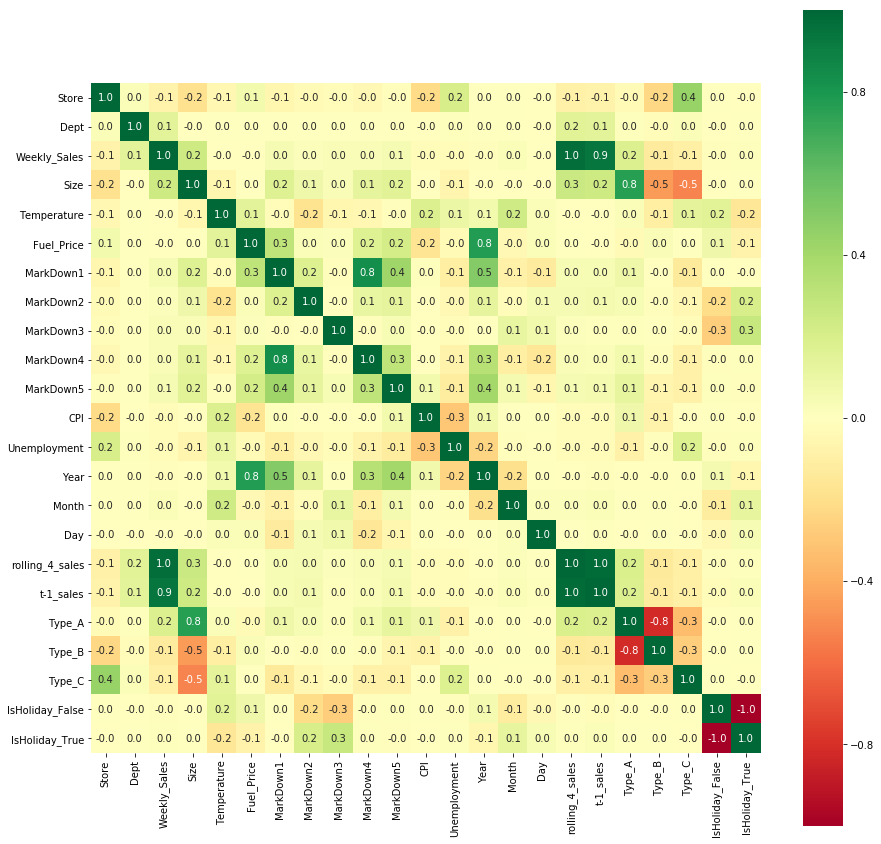

In [14]:
C_mat = train_encoded_df.corr()
fig = plt.figure(figsize = (15,15))

sb.heatmap(C_mat, vmin =-1, vmax = 1, square=True, cmap='RdYlGn', annot=True, fmt='.1f')
plt.show()

### Train-test split

In [15]:
target = train_encoded_df['Weekly_Sales'].values
target = target.reshape(-1,1)
features = train_encoded_df.drop('Weekly_Sales', axis=1)

In [16]:
X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=42)

### Scale and transform the data

In [17]:
X_scaler = MinMaxScaler().fit(X_train)
y_scaler = MinMaxScaler().fit(y_train)

X_train_scaled = X_scaler.transform(X_train)
y_train_scaled = y_scaler.transform(y_train)
X_test_scaled = X_scaler.transform(X_test)
y_test_scaled = y_scaler.transform(y_test)

### Neural Network

In [18]:
#Create a normal sequential neural network
nn_model = Sequential()
nn_model.add(Dense(units=32, kernel_initializer='normal', activation='relu', input_dim=len(X_train.columns))) # hidden and input layers
nn_model.add(Dense(units=1, kernel_initializer='normal',activation='linear')) # output layer
nn_model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32)                736       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 769
Trainable params: 769
Non-trainable params: 0
_________________________________________________________________


Instructions for updating:
Use tf.cast instead.
Epoch 1/50
 - 9s - loss: 0.0033 - mean_absolute_error: 0.0033
Epoch 2/50
 - 8s - loss: 0.0029 - mean_absolute_error: 0.0029
Epoch 3/50
 - 8s - loss: 0.0028 - mean_absolute_error: 0.0028
Epoch 4/50
 - 9s - loss: 0.0027 - mean_absolute_error: 0.0027
Epoch 5/50
 - 8s - loss: 0.0027 - mean_absolute_error: 0.0027
Epoch 6/50
 - 8s - loss: 0.0027 - mean_absolute_error: 0.0027
Epoch 7/50
 - 7s - loss: 0.0027 - mean_absolute_error: 0.0027
Epoch 8/50
 - 7s - loss: 0.0027 - mean_absolute_error: 0.0027
Epoch 9/50
 - 8s - loss: 0.0027 - mean_absolute_error: 0.0027
Epoch 10/50
 - 8s - loss: 0.0027 - mean_absolute_error: 0.0027
Epoch 11/50
 - 7s - loss: 0.0026 - mean_absolute_error: 0.0026
Epoch 12/50
 - 8s - loss: 0.0026 - mean_absolute_error: 0.0026
Epoch 13/50
 - 7s - loss: 0.0026 - mean_absolute_error: 0.0026
Epoch 14/50
 - 8s - loss: 0.0026 - mean_absolute_error: 0.0026
Epoch 15/50
 - 7s - loss: 0.0026 - mean_absolute_error: 0.0026
Epoch 16/50
 - 7

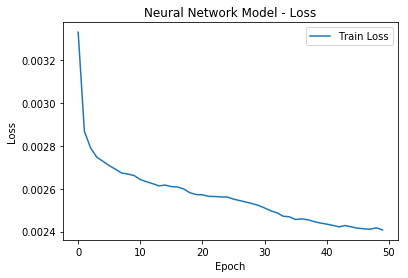

In [19]:
# opt = optimizers.Adam(lr=0.001, decay = 0.005)

nn_model.compile(optimizer= 'adam',
                loss='mean_absolute_error',
                metrics=['mean_absolute_error'])
    
nn_model_var = nn_model.fit(
                X_train_scaled,
                y_train_scaled,
                epochs=50,
                verbose=2)

plt.plot(nn_model_var.history['loss'])
plt.title('Neural Network Model - Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train Loss'], loc='upper right')
plt.show()

In [20]:
nn_model_train_loss, nn_model_train_accuracy = nn_model.evaluate(
    X_train_scaled, y_train_scaled, verbose=2)
print(
    f"Normal Neural Network Evaluation - Train Loss: {nn_model_train_loss}, Train Accuracy: {nn_model_train_accuracy}")

Normal Neural Network Evaluation - Train Loss: 0.0025045624459160147, Train Accuracy: 0.0025045624459160147


In [21]:
y_predicted_nn = nn_model.predict(X_test_scaled)

### Deep Neural Network

In [18]:
dnn_model = Sequential()
dnn_model.add(Dense(units=128, kernel_initializer='normal', activation='relu', input_dim=len(X_train.columns))) # hidden and input layers
dnn_model.add(Dense(units=64, kernel_initializer='normal', activation='relu')) # hidden and input layers
dnn_model.add(Dense(units=32, kernel_initializer='normal', activation='relu')) # hidden and input layers
dnn_model.add(Dense(units=1, kernel_initializer='normal',activation='linear')) # output layer

dnn_model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               2944      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 13,313
Trainable params: 13,313
Non-trainable params: 0
_________________________________________________________________


In [19]:
#Define a checkpoint callback
checkpoint_name = 'Weights-{epoch:03d}--{val_loss:.5f}.hdf5' 
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
callbacks_list = [checkpoint]

In [24]:
# opt = optimizers.Adam(lr=0.001, decay = 0.005)

# dnn_model.compile(optimizer=opt,
#               loss='mean_absolute_error',
#               metrics=['mean_absolute_error'])

# dnn_model_var = dnn_model.fit(
#                         X_train_scaled,
#                         y_train_scaled,
#                         epochs=50,
#                         shuffle=True,
#                         verbose=2,
#                         batch_size=32, 
#                         validation_split = 0.33,
#                         callbacks=callbacks_list
#                     )

# plt.plot(dnn_model_var.history['loss'])
# plt.plot(dnn_model_var.history['val_loss'])
# plt.title('Deep Neural Network Model Loss (lr=0.001, decay = 0.005)')
# plt.ylabel('Loss')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Test'], loc='upper right')
# plt.show()

In [25]:
# opt = optimizers.Adam(lr=0.001, decay = 0.05, amsgrad = True)

# dnn_model_var = dnn_model.fit(
#                         X_train_scaled,
#                         y_train_scaled,
#                         epochs=50,
#                         shuffle=True,
#                         verbose=2,
#                         batch_size=32, 
#                         validation_split = 0.33,
#                         callbacks=callbacks_list
#                     )

# plt.plot(dnn_model_var.history['loss'])
# plt.plot(dnn_model_var.history['val_loss'])
# plt.title('Deep Neural Network Model Loss (lr=0.001, decay = 0.05, amsgrad = True)')
# plt.ylabel('Loss')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Test'], loc='upper right')
# plt.show()

In [20]:
dnn_model.compile(optimizer='adam',
              loss='mean_absolute_error',
              metrics=['mean_absolute_error'])

dnn_model_var = dnn_model.fit(
                        X_train_scaled,
                        y_train_scaled,
                        epochs=50,
                        verbose=2,
                        batch_size=32, 
                        validation_split = 0.33,
                        callbacks=callbacks_list
                    )

Instructions for updating:
Use tf.cast instead.
Train on 211837 samples, validate on 104338 samples
Epoch 1/50
 - 11s - loss: 0.0035 - mean_absolute_error: 0.0035 - val_loss: 0.0028 - val_mean_absolute_error: 0.0028

Epoch 00001: val_loss improved from inf to 0.00278, saving model to Weights-001--0.00278.hdf5
Epoch 2/50
 - 14s - loss: 0.0029 - mean_absolute_error: 0.0029 - val_loss: 0.0030 - val_mean_absolute_error: 0.0030

Epoch 00002: val_loss did not improve from 0.00278
Epoch 3/50
 - 10s - loss: 0.0028 - mean_absolute_error: 0.0028 - val_loss: 0.0030 - val_mean_absolute_error: 0.0030

Epoch 00003: val_loss did not improve from 0.00278
Epoch 4/50
 - 13s - loss: 0.0027 - mean_absolute_error: 0.0027 - val_loss: 0.0034 - val_mean_absolute_error: 0.0034

Epoch 00004: val_loss did not improve from 0.00278
Epoch 5/50
 - 11s - loss: 0.0027 - mean_absolute_error: 0.0027 - val_loss: 0.0026 - val_mean_absolute_error: 0.0026

Epoch 00005: val_loss improved from 0.00278 to 0.00264, saving model


Epoch 00043: val_loss did not improve from 0.00222
Epoch 44/50
 - 12s - loss: 0.0023 - mean_absolute_error: 0.0023 - val_loss: 0.0023 - val_mean_absolute_error: 0.0023

Epoch 00044: val_loss did not improve from 0.00222
Epoch 45/50
 - 11s - loss: 0.0023 - mean_absolute_error: 0.0023 - val_loss: 0.0023 - val_mean_absolute_error: 0.0023

Epoch 00045: val_loss did not improve from 0.00222
Epoch 46/50
 - 11s - loss: 0.0023 - mean_absolute_error: 0.0023 - val_loss: 0.0023 - val_mean_absolute_error: 0.0023

Epoch 00046: val_loss did not improve from 0.00222
Epoch 47/50
 - 12s - loss: 0.0023 - mean_absolute_error: 0.0023 - val_loss: 0.0024 - val_mean_absolute_error: 0.0024

Epoch 00047: val_loss did not improve from 0.00222
Epoch 48/50
 - 12s - loss: 0.0023 - mean_absolute_error: 0.0023 - val_loss: 0.0023 - val_mean_absolute_error: 0.0023

Epoch 00048: val_loss did not improve from 0.00222
Epoch 49/50
 - 12s - loss: 0.0023 - mean_absolute_error: 0.0023 - val_loss: 0.0023 - val_mean_absolute_

(array([ 3.,  2.,  1.,  5., 16., 81., 14.,  5.,  0.,  1.]),
 array([-0.7810529 , -0.6475396 , -0.5140263 , -0.38051298, -0.24699968,
        -0.11348638,  0.02002692,  0.15354022,  0.28705353,  0.42056683,
         0.5540801 ], dtype=float32),
 <a list of 10 Patch objects>)

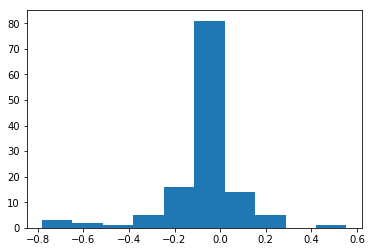

In [34]:
weights = dnn_model.get_weights()
x = weights[0][0]
plt.hist(x)

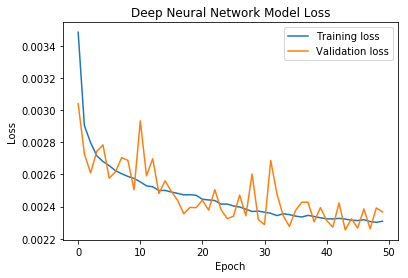

<Figure size 432x288 with 0 Axes>

In [27]:
plt.plot(dnn_model_var.history['loss'])
plt.plot(dnn_model_var.history['val_loss'])
plt.title('Deep Neural Network Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training loss', 'Validation loss'], loc='upper right')
plt.figure().savefig('Deep Neural Network Model - Loss')
plt.show()

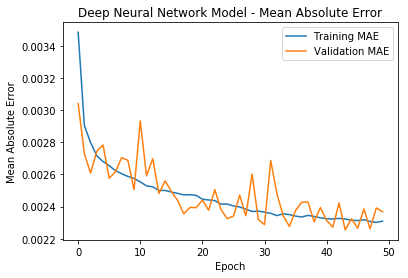

<Figure size 432x288 with 0 Axes>

In [28]:
plt.plot(dnn_model_var.history['mean_absolute_error'])
plt.plot(dnn_model_var.history['val_mean_absolute_error'])
plt.title('Deep Neural Network Model - Mean Absolute Error')
plt.ylabel('Mean Absolute Error')
plt.xlabel('Epoch')
plt.legend(['Training MAE', 'Validation MAE'], loc='upper right')
plt.figure().savefig('Deep Neural Network Model - Mean Absolute Error')
plt.show()

In [29]:
dnn_model_test_loss, dnn_model_test_accuracy = dnn_model.evaluate(
    X_test_scaled, y_test_scaled, verbose=2)
print(
    f"Deep Neural Network Evaluation - Train Loss: {dnn_model_test_loss}, Train Accuracy: {dnn_model_test_accuracy}")

Deep Neural Network Evaluation - Train Loss: 0.0023898532488382646, Train Accuracy: 0.0023898532488382646


In [30]:
y_predicted_dnn = dnn_model.predict(X_test_scaled)

## Actual Results

### Predictions

In [31]:
# Inverse minmaxscaler
weekly_sales = y_scaler.inverse_transform(y_test_scaled)
predicted_sales_nn = y_scaler.inverse_transform(y_predicted_nn)
predicted_sales_dnn = y_scaler.inverse_transform(y_predicted_dnn)

#Ravel
weekly_sales_raveled = weekly_sales.ravel()
predicted_sales_nn_raveled = predicted_sales_nn.ravel()
predicted_sales_dnn_raveled = predicted_sales_dnn.ravel()


Actual_Results_df = pd.DataFrame({"Weekly Sales": weekly_sales_raveled,
                                  "Predicted Sales_NN": predicted_sales_nn_raveled,
                                  "Predicted Sales_DNN": predicted_sales_dnn_raveled,
                                 })

#Export dataframe
Actual_Results_df.to_csv('Actual_Results.csv')

In [32]:
Actual_Results_df.head()

,Weekly Sales,Predicted Sales_NN,Predicted Sales_DNN
0,329.00,1944.612793,1868.321777
1,3936.64,9973.365234,4003.861816
2,61691.49,57341.214844,56284.792969
3,11097.86,10534.906250,9950.676758
4,8462.08,13487.179688,13395.901367


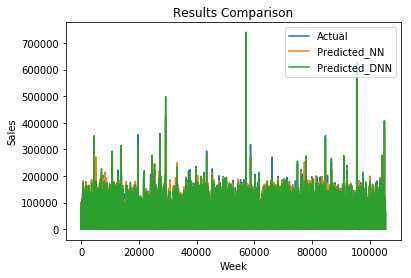

<Figure size 432x288 with 0 Axes>

In [33]:
plt.plot(Actual_Results_df['Weekly Sales'])
plt.plot(Actual_Results_df['Predicted Sales_NN'])
plt.plot(Actual_Results_df['Predicted Sales_DNN'])
plt.title('Results Comparison')
plt.ylabel('Sales')
plt.xlabel('Week')
plt.legend(['Actual', 'Predicted_NN', 'Predicted_DNN'], loc='upper right')
plt.figure().savefig('Actual_Predicted_Sales')
plt.show()

### Model Losses

In [41]:
Loss_Results_df = pd.DataFrame({"NN Model Loss": nn_model_var.history['loss'],
                                "DNN Train Loss": dnn_model_var.history['loss'],
                                "DNN Validation Loss": dnn_model_var.history['val_loss'],
                                "DNN Train MAE": dnn_model_var.history['mean_absolute_error'],
                                "DNN Validation MAE": dnn_model_var.history['val_mean_absolute_error']
                                 })

Loss_Results_df.to_csv('Loss_Results.csv', index=True)

In [35]:
# test and train - treat separately from start
#lr (adam), relu (alpha - make it 0.01) dropout, add more layers to dnn (to the power of 2), drop date and don't shuffle
# previous week/ rolling avg of sales (drop first row)
# t-1 and t column
# Try vanilla and stacked LSTMs (shampoo example) https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/
#Edit encoded_df to have one-hot columns for dept(99), store(45), year(4), month(12), day(7) and run model again to check accuracy
#Save model